In [1]:
import pandas as pd
import math
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
symbols = ['NEE','SO','DUK','SRE','EXC','AEP','D','PEG','XEL','ED']
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2024,1,1)
df = yf.download(symbols, start=start, end=end)

[*********************100%***********************]  10 of 10 completed


In [3]:
import warnings

# Ignore specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated*")

In [4]:
# Moving Average - returns df of signal (-1,0,1)
def moving_average(ticker, short, long, start, end):
    prices = df['Adj Close'].loc[start:end]
    
    l_window = prices[ticker].rolling(long).mean()
    s_window = prices[ticker].rolling(short).mean()
    
    signal=(s_window>l_window)*2-1+l_window.isnull()
    return signal

In [5]:
# Tests
# signal = moving_average('GS',50,20,datetime.datetime(2009,1,1),datetime.datetime(2024,1,1))

In [6]:
# Backtest - return portfolio return (%) and df of value/time
def backtest(ticker, initial_capital, signal,start,end):
    # isolate price data
    data = df['Adj Close'][ticker].loc[start:end]
    data = pd.DataFrame(data)
    
    # add signals
    data['signal'] = signal.values
    
    # calculate # of shares based on initial capital
    num_shares = initial_capital/data.iloc[0,0]
    
    # compute the PNL
    data['holdings'] = data['signal'] * num_shares * data.iloc[:,0] #go short or long
    data['pos_diff'] = data['signal'].diff() * num_shares
    data['cash'] = initial_capital - (data['pos_diff'] * data.iloc[:,0]).cumsum()
    data['value'] = data['cash'] + data['holdings']
    
    # plt.plot(data['value'])
    portfolio_return=(data['value'][-1]-initial_capital)/initial_capital
    return portfolio_return,data

In [7]:
# Test
# portfolio_return,data = backtest('GS', 1000, moving_average('GS',20,50,datetime.datetime(2009,1,1),datetime.datetime(2024,1,1)),datetime.datetime(2009,1,1),datetime.datetime(2024,1,1))

In [8]:
# Optimizer - return the optimized short and long windows for a ticker
def optimizer(ticker, start, end):
    max_return = -1
    short,long = 0,0
    
    for i in range(5,50,5):
        for j in range(50,200,5):
            signal = moving_average(ticker,i,j,start,end)
            portfolio_return,data = backtest(ticker,100000,signal,start,end)
            if portfolio_return>max_return:
                max_return = portfolio_return
                short,long = i,j
    return short,long

In [9]:
# Test
# test = optimizer('GS',datetime.datetime(2018,1,1),datetime.datetime(2024,1,1))

In [17]:
# Calculate Optimal Parameters
parameters = {}
start,end = datetime.datetime(2018,1,1),datetime.datetime(2024,1,1)

for symbol in symbols:
    parameters[symbol] = optimizer(symbol,start,end)
print("Optimal Parameters: ", parameters)

Optimal Parameters:  {'NEE': (15, 50), 'SO': (5, 50), 'DUK': (30, 195), 'SRE': (10, 155), 'EXC': (45, 145), 'AEP': (10, 190), 'D': (5, 150), 'PEG': (45, 140), 'XEL': (5, 55), 'ED': (45, 195)}


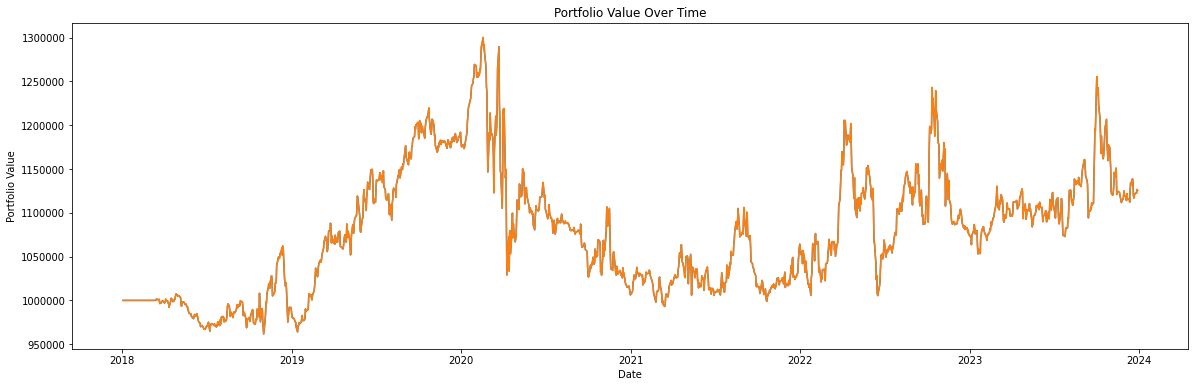

In [16]:
# Backtest Portfolio
portfolio = pd.DataFrame(df,columns=['value'])
portfolio['value'] = 0

start,end = datetime.datetime(2018,1,1),datetime.datetime(2024,9,5)
for symbol in symbols:
    signal = moving_average(symbol,parameters[symbol][0],parameters[symbol][1],start,end)
    portfolio_return, data = backtest(symbol,100000,signal,start,end)
    portfolio['value'] += data['value'].astype(float)

plt.figure(figsize=(20, 6))
plt.plot(portfolio['value'])

from matplotlib.ticker import ScalarFormatter

# Plot the portfolio value
plt.plot(portfolio['value'])

ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')

# Show the plot
plt.show()